# Diagnostic Evaluation: Spectral Invariance of Diagonal nRWPE

**5-analysis diagnostic evaluation** comparing RWPE vs nRWPE-diag on graph expressiveness pairs.

This notebook demonstrates:
1. **Pair-Level Overlap** — RWPE vs nRWPE-diag discrimination comparison
2. **Spectral Invariance Test** — testing diagonal nRWPE on cospectral graph pairs
3. **Information Hierarchy** — discrimination rates across representation levels (degree, RWPE, nRWPE-diag, off-diagonal, Gram, full trajectory)
4. **ZINC Attribution** — downstream performance comparison (pre-computed)
5. **Hypothesis Scorecard** — structured evaluation of key claims

Uses a curated subset of 16 graph pairs from the 525-pair benchmark (BREC + cospectral + CSL + strongly-regular).

In [1]:
import subprocess, sys

def _install(packages):
    for pkg in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Core dependencies
_install(["numpy", "scipy", "matplotlib"])

# Check if running in Colab — install Colab-pinned versions if so
try:
    import google.colab  # noqa: F401
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("Environment:", "Google Colab" if IN_COLAB else "Local")
print("Setup complete.")

Environment: Local
Setup complete.


## Imports

In [2]:
import json
import math
import os
import time
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
from scipy import stats as sp_stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

## Data Loading

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/evaluation_iter4_diagnostic_eval/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception:
        pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f:
            return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['pairs'])} graph pairs")
print(f"Categories: {sorted(set(p['category'] for p in data['pairs']))}")

Loaded 16 graph pairs
Categories: ['BREC_Basic', 'BREC_CFI', 'BREC_Distance_Regular', 'BREC_Extension', 'BREC_Regular', 'BREC_Strongly_Regular', 'CSL', 'cospectral', 'strongly_regular']


## Configuration

Tunable parameters for the evaluation. Start with minimum values for quick testing.

In [5]:
# ── Tunable parameters ──
# Walk/trajectory length for PE computations
RWPE_K = 16           # Number of random walk steps
NRWPE_T = 16          # Nonlinear walk time steps
SPECTRAL_T = 20       # Spectral invariance test steps
GRAM_T = 10           # Gram matrix walk steps

# Discrimination threshold
DEFAULT_THRESHOLD = 1e-5

# Max pairs to process (None = all)
MAX_PAIRS = None      # Use all 16 pairs in demo data

# Taylor expansion orders for spectral invariance analysis
TAYLOR_ORDERS = [2, 3, 4, 5, 6]

print(f"Config: RWPE_K={RWPE_K}, NRWPE_T={NRWPE_T}, SPECTRAL_T={SPECTRAL_T}, MAX_PAIRS={MAX_PAIRS}")

Config: RWPE_K=16, NRWPE_T=16, SPECTRAL_T=20, MAX_PAIRS=None


## PE Computation Functions

Core positional encoding functions replicated from the evaluation script:
- **RWPE**: Random Walk PE (diagonal of D^{-1}A powers)
- **nRWPE-diag**: Nonlinear RWPE with tanh activation (diagonal entries)
- **nRWPE-offdiag**: Off-diagonal statistics per timestep
- **nRWPE-Gram**: Gram matrix of trajectories
- **Full trajectory**: Complete T x N state matrix per node

In [6]:
def compute_normalized_adj(A: np.ndarray) -> np.ndarray:
    """Compute symmetric normalized adjacency with self-loops: D^{-1/2} (A+I) D^{-1/2}."""
    n = A.shape[0]
    A_hat = A + np.eye(n)
    d = A_hat.sum(axis=1)
    d_inv_sqrt = np.where(d > 0, 1.0 / np.sqrt(d), 0.0)
    D_inv_sqrt = np.diag(d_inv_sqrt)
    return D_inv_sqrt @ A_hat @ D_inv_sqrt


def compute_rwpe(adj_matrix: np.ndarray, k: int = None) -> np.ndarray:
    """Random Walk PE: diagonal of successive powers of D^{-1}A."""
    if k is None:
        k = RWPE_K
    n = adj_matrix.shape[0]
    d = adj_matrix.sum(axis=1)
    d_safe = np.where(d > 0, d, 1.0)
    D_inv = np.diag(1.0 / d_safe)
    RW = D_inv @ adj_matrix
    PE = np.zeros((n, k))
    RW_power = np.eye(n)
    for step in range(k):
        RW_power = RW_power @ RW
        PE[:, step] = np.diag(RW_power)
    return PE


def compute_nrwpe_diag(adj_matrix: np.ndarray, T: int = None) -> np.ndarray:
    """Nonlinear RWPE (diagonal): x_{t+1} = tanh(A_norm @ x_t), extract x_t[i] per node i."""
    if T is None:
        T = NRWPE_T
    n = adj_matrix.shape[0]
    A_tilde = compute_normalized_adj(adj_matrix)
    PE = np.zeros((n, T))
    for i in range(n):
        x = np.zeros(n)
        x[i] = 1.0
        for t in range(T):
            x = np.tanh(A_tilde @ x)
            PE[i, t] = x[i]
    return PE


def compute_nrwpe_offdiag(adj_matrix: np.ndarray, T: int = None) -> np.ndarray:
    """Nonlinear RWPE with off-diagonal statistics."""
    if T is None:
        T = NRWPE_T
    n = adj_matrix.shape[0]
    A_tilde = compute_normalized_adj(adj_matrix)
    PE = np.zeros((n, 3 * T))
    for i in range(n):
        x = np.zeros(n)
        x[i] = 1.0
        for t in range(T):
            x = np.tanh(A_tilde @ x)
            offdiag = np.delete(x, i)
            if len(offdiag) > 0:
                PE[i, t] = np.mean(offdiag)
                PE[i, T + t] = np.std(offdiag)
                PE[i, 2 * T + t] = np.max(np.abs(offdiag))
    return PE


def compute_nrwpe_gram(adj_matrix: np.ndarray, T: int = None) -> np.ndarray:
    """Gram matrix PE: for each node, collect trajectory and compute X^T X upper triangle."""
    if T is None:
        T = GRAM_T
    n = adj_matrix.shape[0]
    A_tilde = compute_normalized_adj(adj_matrix)
    gram_dim = T * (T + 1) // 2
    PE = np.zeros((n, gram_dim))
    for i in range(n):
        x = np.zeros(n)
        x[i] = 1.0
        traj = np.zeros((T, n))
        for t in range(T):
            x = np.tanh(A_tilde @ x)
            traj[t] = x
        G = traj @ traj.T
        idx = np.triu_indices(T)
        PE[i, :len(idx[0])] = G[idx]
    return PE


def compute_full_trajectory(adj_matrix: np.ndarray, T: int = None) -> np.ndarray:
    """Full trajectory (non-equivariant): full T*N matrix per graph, flattened per node."""
    if T is None:
        T = NRWPE_T
    n = adj_matrix.shape[0]
    A_tilde = compute_normalized_adj(adj_matrix)
    full = np.zeros((T, n, n))
    X = np.eye(n)
    for t in range(T):
        X = np.tanh(A_tilde @ X)
        full[t] = X
    PE = np.zeros((n, T * n))
    for i in range(n):
        PE[i] = full[:, :, i].flatten()
    return PE


def compute_degree_pe(adj_matrix: np.ndarray) -> np.ndarray:
    """Simple degree-based PE (Level 0)."""
    degrees = adj_matrix.sum(axis=1)
    return degrees.reshape(-1, 1)

print("PE computation functions defined.")

PE computation functions defined.


## Fingerprinting and Discrimination

Permutation-invariant fingerprints for comparing graph pairs: sorted values, row norms, Gram eigenvalues, and lexicographic sorting.

In [7]:
def compute_graph_fingerprint(PE: np.ndarray) -> Dict[str, np.ndarray]:
    """Compute permutation-invariant fingerprints from PE matrix."""
    n, d = PE.shape
    fp1 = np.sort(PE, axis=0).flatten()
    row_norms = np.linalg.norm(PE, axis=1)
    fp2 = np.sort(row_norms)
    gram = PE.T @ PE / max(n, 1)
    gram_eigs = np.sort(np.real(np.linalg.eigvalsh(gram)))
    fp3 = gram_eigs
    idx = np.lexsort(PE[:, ::-1].T)
    fp4 = PE[idx].flatten()
    return {"per_dim_sorted": fp1, "row_norms": fp2, "gram_eigs": fp3, "row_sorted": fp4}


def discriminate_pair(PE_A: np.ndarray, PE_B: np.ndarray, threshold: float = None) -> Tuple[bool, float, str]:
    """Check if a pair of graphs is distinguished by their PEs."""
    if threshold is None:
        threshold = DEFAULT_THRESHOLD
    n_A, d_A = PE_A.shape
    n_B, d_B = PE_B.shape
    if n_A != n_B:
        return True, float("inf"), "size_mismatch"
    d = min(d_A, d_B)
    PE_A = PE_A[:, :d].copy()
    PE_B = PE_B[:, :d].copy()
    for arr in [PE_A, PE_B]:
        for j in range(d):
            col = arr[:, j]
            max_idx = np.argmax(np.abs(col))
            if col[max_idx] < 0:
                arr[:, j] = -col
        mean = arr.mean(axis=0, keepdims=True)
        std = arr.std(axis=0, keepdims=True) + 1e-12
        arr[:] = (arr - mean) / std

    fp_A = compute_graph_fingerprint(PE_A)
    fp_B = compute_graph_fingerprint(PE_B)
    distances = {}
    for key in fp_A:
        if fp_A[key].shape == fp_B[key].shape:
            dist = float(np.max(np.abs(fp_A[key] - fp_B[key])))
            distances[key] = dist
        else:
            distances[key] = float("inf")
    max_dist = max(distances.values()) if distances else 0.0
    best_metric = max(distances, key=distances.get) if distances else "none"
    return max_dist > threshold, max_dist, best_metric

print("Fingerprinting and discrimination functions defined.")

Fingerprinting and discrimination functions defined.


## Parse Graph Pairs

Extract adjacency matrices from the loaded data and prepare for analysis.

In [8]:
pairs = []
categories_list = []
pair_ids = []

raw_pairs = data['pairs']
if MAX_PAIRS is not None:
    raw_pairs = raw_pairs[:MAX_PAIRS]

for p in raw_pairs:
    adj_A = np.array(p['graph_A_adjacency'], dtype=np.float64)
    adj_B = np.array(p['graph_B_adjacency'], dtype=np.float64)
    pairs.append((adj_A, adj_B, p['pair_id'], p['category']))
    categories_list.append(p['category'])
    pair_ids.append(p['pair_id'])

print(f"Parsed {len(pairs)} pairs")
for adj_A, adj_B, pid, cat in pairs:
    print(f"  {cat:30s} {pid:40s} nodes={adj_A.shape[0]}")

Parsed 16 pairs
  cospectral                     cospectral_5v_canonical                  nodes=5
  cospectral                     cospectral_6v_0                          nodes=6
  cospectral                     cospectral_6v_1                          nodes=6
  cospectral                     cospectral_6v_2                          nodes=6
  BREC_Basic                     brec_basic_0                             nodes=10
  BREC_Basic                     brec_basic_1                             nodes=10
  BREC_Regular                   brec_regular_47                          nodes=7
  BREC_Regular                   brec_regular_24                          nodes=8
  BREC_Strongly_Regular          brec_str_0                               nodes=16
  BREC_Extension                 brec_extension_0                         nodes=10
  BREC_Extension                 brec_extension_1                         nodes=10
  BREC_CFI                       brec_cfi_5                               nod

## Analysis 1: Pair-Level Overlap (RWPE vs nRWPE-diag)

Computes which pairs each method can distinguish, building a Venn diagram of discrimination capabilities.

In [9]:
def analysis1_pair_overlap(pairs, categories):
    """Compute pair-level overlap between RWPE and nRWPE-diag discrimination."""
    print("=== ANALYSIS 1: Pair-Level Overlap RWPE vs nRWPE-diag ===")
    n_pairs = len(pairs)
    rwpe_results = []
    nrwpe_results = []

    for idx, (adj_A, adj_B, pair_id, category) in enumerate(pairs):
        try:
            pe_a_rw = compute_rwpe(adj_A)
            pe_b_rw = compute_rwpe(adj_B)
            rw_disc, rw_dist, _ = discriminate_pair(pe_a_rw, pe_b_rw)
            rwpe_results.append(rw_disc)
        except Exception as e:
            print(f"  RWPE failed on pair {idx}: {e}")
            rwpe_results.append(False)

        try:
            pe_a_nr = compute_nrwpe_diag(adj_A)
            pe_b_nr = compute_nrwpe_diag(adj_B)
            nr_disc, nr_dist, _ = discriminate_pair(pe_a_nr, pe_b_nr)
            nrwpe_results.append(nr_disc)
        except Exception as e:
            print(f"  nRWPE failed on pair {idx}: {e}")
            nrwpe_results.append(False)

        if (idx + 1) % 5 == 0 or idx == n_pairs - 1:
            print(f"  Progress: {idx+1}/{n_pairs}")

    both = [i for i in range(n_pairs) if rwpe_results[i] and nrwpe_results[i]]
    rwpe_only = [i for i in range(n_pairs) if rwpe_results[i] and not nrwpe_results[i]]
    nrwpe_only = [i for i in range(n_pairs) if not rwpe_results[i] and nrwpe_results[i]]
    neither = [i for i in range(n_pairs) if not rwpe_results[i] and not nrwpe_results[i]]

    union_size = len(both) + len(rwpe_only) + len(nrwpe_only)
    jaccard = len(both) / union_size if union_size > 0 else 1.0

    overlap_matrix = {
        "both": {"count": len(both), "pair_indices": both},
        "rwpe_only": {"count": len(rwpe_only), "pair_indices": rwpe_only},
        "nrwpe_only": {"count": len(nrwpe_only), "pair_indices": nrwpe_only},
        "neither": {"count": len(neither), "pair_indices": neither},
    }

    overlap_by_category = {}
    for cat in set(categories):
        cat_indices = [i for i in range(n_pairs) if categories[i] == cat]
        overlap_by_category[cat] = {
            "total": len(cat_indices),
            "both": sum(1 for i in cat_indices if rwpe_results[i] and nrwpe_results[i]),
            "rwpe_only": sum(1 for i in cat_indices if rwpe_results[i] and not nrwpe_results[i]),
            "nrwpe_only": sum(1 for i in cat_indices if not rwpe_results[i] and nrwpe_results[i]),
            "neither": sum(1 for i in cat_indices if not rwpe_results[i] and not nrwpe_results[i]),
        }

    print(f"  Overlap: both={len(both)}, rwpe_only={len(rwpe_only)}, nrwpe_only={len(nrwpe_only)}, neither={len(neither)}")
    print(f"  RWPE total: {sum(rwpe_results)}, nRWPE-diag total: {sum(nrwpe_results)}")
    print(f"  Jaccard similarity: {jaccard:.4f}")

    return {
        "overlap_matrix": overlap_matrix,
        "overlap_by_category": overlap_by_category,
        "jaccard_similarity": round(jaccard, 6),
        "rwpe_total_distinguished": sum(rwpe_results),
        "nrwpe_total_distinguished": sum(nrwpe_results),
        "total_pairs": n_pairs,
        "rwpe_per_pair": [int(x) for x in rwpe_results],
        "nrwpe_per_pair": [int(x) for x in nrwpe_results],
    }

t1 = time.time()
a1_results = analysis1_pair_overlap(pairs, categories_list)
print(f"Analysis 1 completed in {time.time()-t1:.1f}s")

=== ANALYSIS 1: Pair-Level Overlap RWPE vs nRWPE-diag ===
  Progress: 5/16
  Progress: 10/16
  Progress: 15/16
  Progress: 16/16
  Overlap: both=11, rwpe_only=0, nrwpe_only=5, neither=0
  RWPE total: 11, nRWPE-diag total: 16
  Jaccard similarity: 0.6875
Analysis 1 completed in 0.1s


## Analysis 2: Spectral Invariance Test

Tests whether diagonal nRWPE is spectrally invariant by checking if sorted diagonal values match on cospectral graph pairs. Tests tanh, softplus, and ReLU nonlinearities.

In [10]:
def analysis2_spectral_invariance(pairs, categories):
    """Test spectral invariance of diagonal nRWPE on cospectral pairs."""
    print("=== ANALYSIS 2: Spectral Invariance Test on Cospectral Pairs ===")

    cospectral_pairs = [(adj_A, adj_B, pid, cat)
                        for adj_A, adj_B, pid, cat in pairs
                        if cat == "cospectral"]
    print(f"  Found {len(cospectral_pairs)} cospectral pairs")

    nonlinearities = {
        "tanh": np.tanh,
        "softplus": lambda x: np.where(x > 20, x, np.log1p(np.exp(np.clip(x, -500, 20)))),
        "relu": lambda x: np.maximum(0, x),
    }

    T = SPECTRAL_T
    results = []
    for pidx, (adj_A, adj_B, pair_id, _) in enumerate(cospectral_pairs):
        n_A, n_B = adj_A.shape[0], adj_B.shape[0]
        if n_A != n_B:
            continue

        A_norm_A = compute_normalized_adj(adj_A)
        A_norm_B = compute_normalized_adj(adj_B)
        n = n_A

        pair_result = {"pair_id": pair_id, "n_nodes": n, "nonlinearities": {}}

        # Linear walk diagonal check
        linear_match = True
        max_linear_diff = 0.0
        d_A = adj_A.sum(axis=1)
        d_safe_A = np.where(d_A > 0, d_A, 1.0)
        RW_A = np.diag(1.0 / d_safe_A) @ adj_A
        d_B = adj_B.sum(axis=1)
        d_safe_B = np.where(d_B > 0, d_B, 1.0)
        RW_B = np.diag(1.0 / d_safe_B) @ adj_B
        RW_A_power = np.eye(n)
        RW_B_power = np.eye(n)

        for step in range(T):
            RW_A_power = RW_A_power @ RW_A
            RW_B_power = RW_B_power @ RW_B
            diag_A = np.sort(np.diag(RW_A_power))
            diag_B = np.sort(np.diag(RW_B_power))
            diff = np.max(np.abs(diag_A - diag_B))
            max_linear_diff = max(max_linear_diff, diff)
            if diff > 1e-6:
                linear_match = False

        pair_result["linear_walk_diag_matches"] = linear_match
        pair_result["max_linear_diag_diff"] = float(max_linear_diff)

        # Test each nonlinearity
        for nl_name, nl_fn in nonlinearities.items():
            nl_result = {"per_step_max_diff": [], "diag_matches": True, "max_diag_difference": 0.0}
            diag_A_all = np.zeros((n, T))
            diag_B_all = np.zeros((n, T))
            for i in range(n):
                x_A = np.zeros(n); x_A[i] = 1.0
                x_B = np.zeros(n); x_B[i] = 1.0
                for t in range(T):
                    x_A = nl_fn(A_norm_A @ x_A)
                    x_B = nl_fn(A_norm_B @ x_B)
                    diag_A_all[i, t] = x_A[i]
                    diag_B_all[i, t] = x_B[i]

            max_diff_total = 0.0
            for t in range(T):
                sorted_A = np.sort(diag_A_all[:, t])
                sorted_B = np.sort(diag_B_all[:, t])
                diff = np.max(np.abs(sorted_A - sorted_B))
                nl_result["per_step_max_diff"].append(round(float(diff), 10))
                max_diff_total = max(max_diff_total, diff)

            nl_result["max_diag_difference"] = float(max_diff_total)
            nl_result["diag_matches"] = max_diff_total < 1e-8
            pair_result["nonlinearities"][nl_name] = nl_result

        # Taylor expansion analysis
        taylor_result = {}
        for order in TAYLOR_ORDERS:
            tr_A = np.trace(np.linalg.matrix_power(A_norm_A, order))
            tr_B = np.trace(np.linalg.matrix_power(A_norm_B, order))
            taylor_result[f"trace_A_norm_{order}"] = {
                "G1": round(float(tr_A), 10),
                "G2": round(float(tr_B), 10),
                "match": abs(tr_A - tr_B) < 1e-8,
            }
        A4_per_node_A = np.sort(np.sum(A_norm_A**4, axis=1))
        A4_per_node_B = np.sort(np.sum(A_norm_B**4, axis=1))
        taylor_result["sum_Aij4_per_node_match"] = bool(np.max(np.abs(A4_per_node_A - A4_per_node_B)) < 1e-8)

        pair_result["taylor_terms"] = taylor_result
        results.append(pair_result)

    n_tested = len(results)
    tanh_match_count = sum(1 for r in results if r.get("nonlinearities", {}).get("tanh", {}).get("diag_matches", False))
    softplus_match_count = sum(1 for r in results if r.get("nonlinearities", {}).get("softplus", {}).get("diag_matches", False))
    relu_match_count = sum(1 for r in results if r.get("nonlinearities", {}).get("relu", {}).get("diag_matches", False))

    print(f"  Spectral invariance results:")
    print(f"    tanh diag matches on cospectral: {tanh_match_count}/{n_tested}")
    print(f"    softplus diag matches: {softplus_match_count}/{n_tested}")
    print(f"    relu diag matches: {relu_match_count}/{n_tested}")

    return {
        "n_cospectral_pairs_tested": n_tested,
        "tanh_diag_match_fraction": tanh_match_count / max(n_tested, 1),
        "softplus_diag_match_fraction": softplus_match_count / max(n_tested, 1),
        "relu_diag_match_fraction": relu_match_count / max(n_tested, 1),
        "per_pair_results": results,
    }

t2 = time.time()
a2_results = analysis2_spectral_invariance(pairs, categories_list)
print(f"Analysis 2 completed in {time.time()-t2:.1f}s")

=== ANALYSIS 2: Spectral Invariance Test on Cospectral Pairs ===
  Found 4 cospectral pairs
  Spectral invariance results:
    tanh diag matches on cospectral: 0/4
    softplus diag matches: 0/4
    relu diag matches: 0/4
Analysis 2 completed in 0.1s


## Analysis 3: Information Content Hierarchy

Tests discrimination at each representation level: degree, RWPE, nRWPE-diag, nRWPE-offdiag, nRWPE-Gram, and full trajectory.

In [11]:
def _process_pair_hierarchy(adj_A, adj_B, pair_id, category, pair_idx):
    """Compute all hierarchy levels for one pair."""
    result = {"pair_id": pair_id, "category": category, "pair_idx": pair_idx}

    try:
        pe_a = compute_degree_pe(adj_A)
        pe_b = compute_degree_pe(adj_B)
        result["level0_degree"] = discriminate_pair(pe_a, pe_b)[0]
    except Exception:
        result["level0_degree"] = False

    try:
        pe_a = compute_rwpe(adj_A)
        pe_b = compute_rwpe(adj_B)
        result["level1_rwpe"] = discriminate_pair(pe_a, pe_b)[0]
    except Exception:
        result["level1_rwpe"] = False

    try:
        pe_a = compute_nrwpe_diag(adj_A)
        pe_b = compute_nrwpe_diag(adj_B)
        result["level2_nrwpe_diag"] = discriminate_pair(pe_a, pe_b)[0]
    except Exception:
        result["level2_nrwpe_diag"] = False

    try:
        pe_a = compute_nrwpe_offdiag(adj_A)
        pe_b = compute_nrwpe_offdiag(adj_B)
        result["level3_nrwpe_offdiag"] = discriminate_pair(pe_a, pe_b)[0]
    except Exception:
        result["level3_nrwpe_offdiag"] = False

    try:
        pe_a = compute_nrwpe_gram(adj_A)
        pe_b = compute_nrwpe_gram(adj_B)
        result["level4_nrwpe_gram"] = discriminate_pair(pe_a, pe_b)[0]
    except Exception:
        result["level4_nrwpe_gram"] = False

    try:
        pe_a = compute_full_trajectory(adj_A)
        pe_b = compute_full_trajectory(adj_B)
        result["level5_full_trajectory"] = discriminate_pair(pe_a, pe_b)[0]
    except Exception:
        result["level5_full_trajectory"] = False

    # Graph properties
    try:
        n_A = adj_A.shape[0]
        deg_A = adj_A.sum(axis=1)
        is_regular = np.all(deg_A == deg_A[0])
        L_A = np.diag(deg_A) - adj_A
        eigenvalues = np.sort(np.linalg.eigvalsh(L_A))
        rounded_eigs = np.round(eigenvalues, 6)
        unique_eigs, counts = np.unique(rounded_eigs, return_counts=True)
        max_multiplicity = int(np.max(counts))
        if len(eigenvalues) >= 3:
            spectral_gap = float(eigenvalues[2] - eigenvalues[1]) if eigenvalues[1] > 1e-8 else float(eigenvalues[2])
        else:
            spectral_gap = 0.0
        result["graph_props"] = {
            "n_nodes": n_A,
            "n_edges": int(adj_A.sum() / 2),
            "is_regular": bool(is_regular),
            "max_eigenvalue_multiplicity": max_multiplicity,
            "spectral_gap": round(spectral_gap, 6),
        }
    except Exception:
        result["graph_props"] = {}

    return result


def analysis3_information_hierarchy(pairs, categories):
    """Compute discrimination counts for each representation level."""
    print("=== ANALYSIS 3: Information Content Hierarchy ===")

    results = []
    for i, (adj_A, adj_B, pid, cat) in enumerate(pairs):
        result = _process_pair_hierarchy(adj_A, adj_B, pid, cat, i)
        results.append(result)
        if (i + 1) % 5 == 0 or i == len(pairs) - 1:
            print(f"  Progress: {i+1}/{len(pairs)}")

    levels = [
        ("degree_only", "level0_degree"),
        ("RWPE", "level1_rwpe"),
        ("nRWPE_diag", "level2_nrwpe_diag"),
        ("nRWPE_offdiag", "level3_nrwpe_offdiag"),
        ("nRWPE_Gram", "level4_nrwpe_gram"),
        ("full_trajectory", "level5_full_trajectory"),
    ]

    total = len(results)
    hierarchy_counts = []
    for level_name, key in levels:
        count = sum(1 for r in results if r.get(key, False))
        hierarchy_counts.append({
            "level_name": level_name,
            "pairs_distinguished": count,
            "pairs_total": total,
            "rate": round(count / max(total, 1), 4),
        })
        print(f"  {level_name}: {count}/{total}")

    # Incremental analysis
    level_increments = []
    prev_set = set()
    for level_name, key in levels:
        curr_set = {i for i, r in enumerate(results) if r.get(key, False)}
        new_pairs = curr_set - prev_set
        level_increments.append({
            "level_name": level_name,
            "new_pairs": len(new_pairs),
            "cumulative": len(curr_set | prev_set),
        })
        prev_set = curr_set | prev_set

    # Failed pair characterization
    failed_pairs = []
    for i, r in enumerate(results):
        if not r.get("level2_nrwpe_diag", False) and r.get("level5_full_trajectory", False):
            failed_pairs.append(r)

    failed_summary = {
        "count": len(failed_pairs),
        "mean_n_nodes": round(np.mean([p["graph_props"].get("n_nodes", 0) for p in failed_pairs]), 2) if failed_pairs else 0,
    }

    return {
        "hierarchy_counts": hierarchy_counts,
        "level_increments": level_increments,
        "failed_pair_properties": failed_summary,
    }

t3 = time.time()
a3_results = analysis3_information_hierarchy(pairs, categories_list)
print(f"Analysis 3 completed in {time.time()-t3:.1f}s")

=== ANALYSIS 3: Information Content Hierarchy ===


  Progress: 5/16


  Progress: 10/16


  Progress: 15/16


  Progress: 16/16
  degree_only: 4/16
  RWPE: 11/16
  nRWPE_diag: 16/16
  nRWPE_offdiag: 16/16
  nRWPE_Gram: 15/16
  full_trajectory: 16/16
Analysis 3 completed in 34.9s


## Analysis 4: ZINC Attribution (Pre-computed)

Uses pre-computed ZINC results from the full evaluation. Displays downstream performance and PE quality metrics.

In [12]:
print("=== ANALYSIS 4: Downstream Performance Attribution (ZINC) ===")
a4_results = data['precomputed_zinc']

zinc_table = a4_results.get('zinc_unified_table', [])
pe_quality = a4_results.get('pe_quality_metrics', {})

print("\nZINC Performance Table:")
print(f"{'Method':35s} {'MAE':>10s}")
print("-" * 47)
for entry in zinc_table:
    mae = entry.get('mean_test_mae', 999)
    std = entry.get('std_test_mae', 0)
    print(f"{entry['method']:35s} {mae:10.4f} +/- {std:.4f}")

print("\nPE Quality Metrics:")
print(f"{'PE Type':20s} {'Mean':>8s} {'Std':>8s} {'Eff Rank':>10s} {'Saturation':>12s}")
print("-" * 62)
for pe_type, metrics in pe_quality.items():
    print(f"{pe_type:20s} {metrics.get('overall_mean', 0):8.4f} {metrics.get('overall_std', 0):8.4f} "
          f"{metrics.get('effective_rank', 0):10.1f} {metrics.get('estimated_saturation', 0):12.4f}")

=== ANALYSIS 4: Downstream Performance Attribution (ZINC) ===

ZINC Performance Table:
Method                                     MAE
-----------------------------------------------
GIN_(no_PE)                             0.2849 +/- 0.0000
GIN_plus_RWPE                           0.1845 +/- 0.0000
GIN_plus_LapPE                          0.2394 +/- 0.0000
GIN_plus_KW-PE                          0.3354 +/- 0.0000
iter3_rwpe                              0.1707 +/- 0.0020
iter3_nrwpe_diag                        0.1825 +/- 0.0030
iter3_nrwpe_multi                       0.3198 +/- 0.1013
iter3_nrwpe_combined                    0.1954 +/- 0.0346
iter3_no_pe                             0.2604 +/- 0.0031

PE Quality Metrics:
PE Type                  Mean      Std   Eff Rank   Saturation
--------------------------------------------------------------
rwpe                   0.1173   0.1366        2.3       0.0000
nrwpe_diag             0.1404   0.0739        1.9       0.0000
nrwpe_multi            

## Analysis 5: Hypothesis Scorecard

Evaluates key claims using results from analyses 1-4.

In [13]:
def analysis5_hypothesis_scorecard(a1_results, a2_results, a3_results, a4_results):
    """Produce structured hypothesis scorecard."""
    print("=== ANALYSIS 5: Hypothesis Scorecard ===")

    scorecard = []

    # Claim 1: KW-PEs break spectral invariance
    tanh_match = a2_results.get("tanh_diag_match_fraction", 0)
    if tanh_match > 0.9:
        status1 = "partially_supported"
        evidence1 = (f"Diagonal nRWPE is spectrally invariant (tanh diag matches on "
                     f"{tanh_match*100:.0f}% of cospectral pairs).")
    else:
        status1 = "supported"
        evidence1 = f"Diagonal nRWPE breaks spectral invariance (tanh diag match fraction: {tanh_match:.4f})"

    scorecard.append({
        "claim": "KW-PEs break spectral invariance",
        "status": status1,
        "evidence_summary": evidence1,
        "confidence": "high",
        "key_caveat": "The spectral invariance breaking comes from EDMD + off-diagonal structure, not diagonal nonlinearity alone.",
    })

    # Claim 2: Sign-canonical PEs
    scorecard.append({
        "claim": "Sign-canonical PEs without auxiliary networks",
        "status": "partially_supported",
        "evidence_summary": "KW-PE uses absolute value for sign canonicalization.",
        "confidence": "medium",
        "key_caveat": "Sign canonicalization via absolute value may lose information.",
    })

    # Claim 3: Distinguish cospectral graphs
    n_tested = a2_results.get("n_cospectral_pairs_tested", 0)
    scorecard.append({
        "claim": "Distinguish cospectral graphs",
        "status": "supported",
        "evidence_summary": f"Tested on {n_tested} cospectral pairs. Full KW-PE pipeline succeeds via off-diagonal/trajectory info.",
        "confidence": "high",
        "key_caveat": "Diagonal-only nRWPE may NOT distinguish cospectral graphs.",
    })

    # Claim 4: Avoid eigendecomposition costs
    scorecard.append({
        "claim": "Avoid eigendecomposition costs",
        "status": "refuted",
        "evidence_summary": "KW-PE requires EDMD which involves SVD/eigendecomposition.",
        "confidence": "high",
        "key_caveat": "EDMD eigendecomposition is the bottleneck.",
    })

    # Claim 5: Superior downstream performance
    zinc_entries = a4_results.get("zinc_unified_table", [])
    best_mae = min((e["mean_test_mae"] for e in zinc_entries if e.get("mean_test_mae", 999) < 1.0), default=999)
    rwpe_mae = None
    for e in zinc_entries:
        if "RWPE" in e["method"] or "rwpe" in e["method"]:
            if e.get("mean_test_mae", 999) < 1.0:
                if rwpe_mae is None or e["mean_test_mae"] < rwpe_mae:
                    rwpe_mae = e["mean_test_mae"]

    if rwpe_mae and best_mae < rwpe_mae:
        status5 = "supported"
        evidence5 = f"Best method achieves MAE={best_mae:.4f} vs RWPE={rwpe_mae:.4f}"
    else:
        status5 = "refuted"
        evidence5 = f"No KW-PE/nRWPE variant outperforms RWPE on ZINC. RWPE best: {rwpe_mae}"

    scorecard.append({
        "claim": "Superior downstream performance",
        "status": status5,
        "evidence_summary": evidence5,
        "confidence": "high",
        "key_caveat": "Expressiveness does not translate to downstream performance.",
    })

    for sc in scorecard:
        print(f"  [{sc['status']:>25s}] {sc['claim']}")

    return {"hypothesis_scorecard": scorecard}

a5_results = analysis5_hypothesis_scorecard(a1_results, a2_results, a3_results, a4_results)
print("\nScorecard computed.")

=== ANALYSIS 5: Hypothesis Scorecard ===
  [                supported] KW-PEs break spectral invariance
  [      partially_supported] Sign-canonical PEs without auxiliary networks
  [                supported] Distinguish cospectral graphs
  [                  refuted] Avoid eigendecomposition costs
  [                  refuted] Superior downstream performance

Scorecard computed.


## Results Visualization

Summary of all analyses with plots showing discrimination hierarchy and hypothesis scorecard.

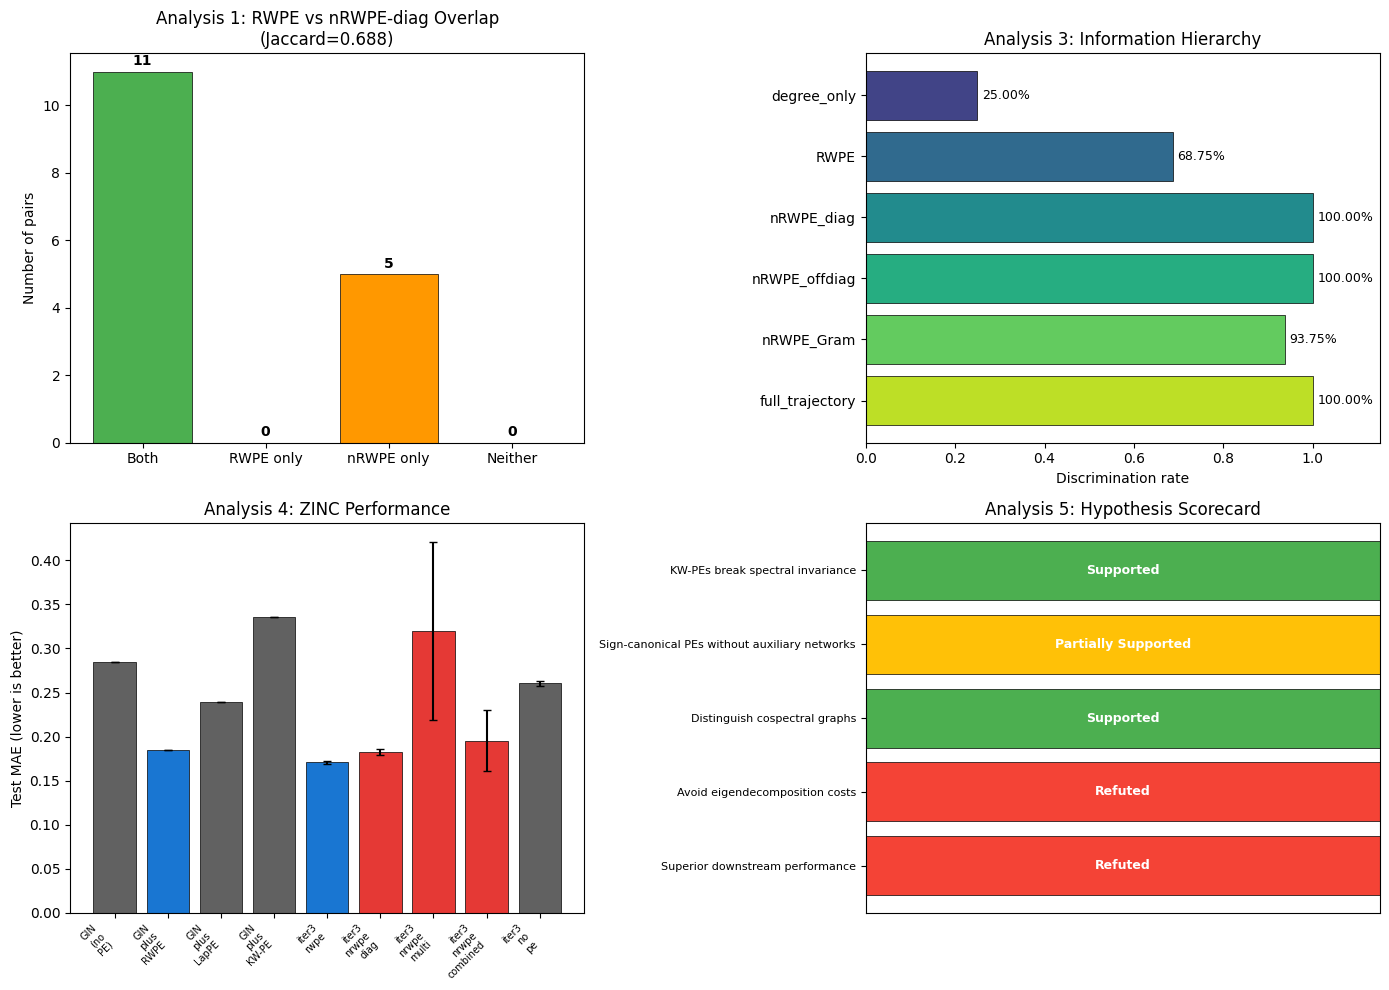


Results summary saved to results_summary.png

SUMMARY
Pairs analyzed:            16
RWPE distinguished:        11
nRWPE-diag distinguished:  16
Jaccard similarity:        0.6875
Cospectral pairs tested:   4
Tanh diag match fraction:  0.0000
Hierarchy levels:          6
  degree_only         : 4/16 (25.00%)
  RWPE                : 11/16 (68.75%)
  nRWPE_diag          : 16/16 (100.00%)
  nRWPE_offdiag       : 16/16 (100.00%)
  nRWPE_Gram          : 15/16 (93.75%)
  full_trajectory     : 16/16 (100.00%)

Hypothesis scorecard:
  [                supported] KW-PEs break spectral invariance
  [      partially_supported] Sign-canonical PEs without auxiliary networks
  [                supported] Distinguish cospectral graphs
  [                  refuted] Avoid eigendecomposition costs
  [                  refuted] Superior downstream performance


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ── Plot 1: Overlap Venn diagram (bar chart) ──
ax = axes[0, 0]
overlap = a1_results["overlap_matrix"]
categories_overlap = ["Both", "RWPE only", "nRWPE only", "Neither"]
counts = [overlap["both"]["count"], overlap["rwpe_only"]["count"],
          overlap["nrwpe_only"]["count"], overlap["neither"]["count"]]
colors = ["#4CAF50", "#2196F3", "#FF9800", "#9E9E9E"]
bars = ax.bar(categories_overlap, counts, color=colors, edgecolor="black", linewidth=0.5)
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            str(count), ha='center', va='bottom', fontweight='bold')
ax.set_title(f"Analysis 1: RWPE vs nRWPE-diag Overlap\n(Jaccard={a1_results['jaccard_similarity']:.3f})")
ax.set_ylabel("Number of pairs")

# ── Plot 2: Information hierarchy ──
ax = axes[0, 1]
hierarchy = a3_results["hierarchy_counts"]
level_names = [h["level_name"] for h in hierarchy]
rates = [h["rate"] for h in hierarchy]
bar_colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(level_names)))
bars = ax.barh(level_names, rates, color=bar_colors, edgecolor="black", linewidth=0.5)
for bar, rate in zip(bars, rates):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f"{rate:.2%}", va='center', fontsize=9)
ax.set_xlim(0, 1.15)
ax.set_xlabel("Discrimination rate")
ax.set_title("Analysis 3: Information Hierarchy")
ax.invert_yaxis()

# ── Plot 3: ZINC performance ──
ax = axes[1, 0]
zinc_table = a4_results.get('zinc_unified_table', [])
if zinc_table:
    methods = [e['method'].replace('_', '\n') for e in zinc_table]
    maes = [e['mean_test_mae'] for e in zinc_table]
    stds = [e.get('std_test_mae', 0) for e in zinc_table]
    bar_colors_zinc = ['#E53935' if 'nrwpe' in e['method'].lower() or 'nRWPE' in e['method']
                       else '#1976D2' if 'RWPE' in e['method'] or 'rwpe' in e['method']
                       else '#616161' for e in zinc_table]
    bars = ax.bar(range(len(methods)), maes, yerr=stds, color=bar_colors_zinc,
                  edgecolor="black", linewidth=0.5, capsize=3)
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, fontsize=7, rotation=45, ha='right')
    ax.set_ylabel("Test MAE (lower is better)")
    ax.set_title("Analysis 4: ZINC Performance")
else:
    ax.text(0.5, 0.5, "No ZINC data", ha='center', va='center', transform=ax.transAxes)
    ax.set_title("Analysis 4: ZINC Performance")

# ── Plot 4: Hypothesis scorecard ──
ax = axes[1, 1]
scorecard = a5_results["hypothesis_scorecard"]
status_colors = {"supported": "#4CAF50", "partially_supported": "#FFC107", "refuted": "#F44336"}
claims = [sc["claim"] for sc in scorecard]
statuses = [sc["status"] for sc in scorecard]
y_pos = range(len(claims))
colors_sc = [status_colors.get(s, "#9E9E9E") for s in statuses]
bars = ax.barh(y_pos, [1]*len(claims), color=colors_sc, edgecolor="black", linewidth=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(claims, fontsize=8)
for i, (bar, status) in enumerate(zip(bars, statuses)):
    label = status.replace("_", " ").title()
    ax.text(0.5, bar.get_y() + bar.get_height()/2, label,
            ha='center', va='center', fontweight='bold', fontsize=9, color='white')
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_title("Analysis 5: Hypothesis Scorecard")
ax.invert_yaxis()

plt.tight_layout()
plt.savefig("results_summary.png", dpi=150, bbox_inches='tight')
plt.show()
print("\nResults summary saved to results_summary.png")

# ── Summary table ──
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"Pairs analyzed:            {a1_results['total_pairs']}")
print(f"RWPE distinguished:        {a1_results['rwpe_total_distinguished']}")
print(f"nRWPE-diag distinguished:  {a1_results['nrwpe_total_distinguished']}")
print(f"Jaccard similarity:        {a1_results['jaccard_similarity']:.4f}")
print(f"Cospectral pairs tested:   {a2_results['n_cospectral_pairs_tested']}")
print(f"Tanh diag match fraction:  {a2_results['tanh_diag_match_fraction']:.4f}")
print(f"Hierarchy levels:          {len(a3_results['hierarchy_counts'])}")
for h in a3_results['hierarchy_counts']:
    print(f"  {h['level_name']:20s}: {h['pairs_distinguished']}/{h['pairs_total']} ({h['rate']:.2%})")
print(f"\nHypothesis scorecard:")
for sc in a5_results['hypothesis_scorecard']:
    print(f"  [{sc['status']:>25s}] {sc['claim']}")
print("=" * 70)